In [1]:
%%capture
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

# !pip install SoccerNet
!pip install lightning timm transformers torchmetrics

In [2]:
# import SoccerNet
# from SoccerNet.Downloader import SoccerNetDownloader
# mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="/content/drive/MyDrive/deformable-detr-soccer-analysis/data")

# mySoccerNetDownloader.downloadDataTask(task="tracking", split=["train", "test", "challenge"])

# mySoccerNetDownloader.downloadDataTask(task="tracking-2023", split=["train", "test", "challenge"])

In [3]:
# from email.mime import image
# from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
# import torch
# from PIL import Image
# import requests

# gdrive_dir = "/content/drive/deformable-detr-soccer-analysis"
# url = "data/tracking/train/SNMOT-060/img1/000002.jpg"
# # image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open(url)

# processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
# model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr")

# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)

# # convert outputs (bounding boxes and class logits) to COCO API
# # let's only keep detections with score > 0.7
# target_sizes = torch.tensor([image.size[::-1]])
# results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)[0]

# for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]
#     print(
#             f"Detected {model.config.id2label[label.item()]} with confidence "
#             f"{round(score.item(), 3)} at location {box}"
#     )

# # plot the image and the bounding boxes
# # also explain what each command does

# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# plt.imshow(image)
# ax = plt.gca()
# # for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
# #     box = [round(i, 2) for i in box.tolist()]
# #     rect = patches.Rectangle(
# #         (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="r", facecolor="none"
# #     )
# #     ax.add_patch(rect)
# #     ax.text(box[0], box[1], f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}", color="red")


# # plot the same image with ground trur
# # gt is located in one directory above the image at gt/gt.txt
# # it is a csv with first column as frame number, second number as class id, next two numbers as bounding box coordinates and the next two as width and height, we can ignore rest of the columns
# # plot the ground truth bounding boxes in green
# # the label is located in gameinfo.ini in one directory above the image
# # it is in this format trackletID_1= player team left;10
# # so for class id 1, the label is player team left;10

# import pandas as pd

# gt = pd.read_csv("data/tracking/train/SNMOT-060/gt/gt.txt", header=None)
# gt.columns = ["frame", "class", "x", "y", "w", "h"] + [f"extra_{i}" for i in range(4)]

# gt = gt[gt["frame"] == 2]

# label = open("data/tracking/train/SNMOT-060/gameinfo.ini").read().split("\n")
# label = [i for i in label if i.startswith("trackletID")]
# label = [i.split("=")[1] for i in label]

# for _, row in gt.iterrows():
#     rect = patches.Rectangle(
#         (row["x"], row["y"]), row["w"], row["h"], linewidth=1, edgecolor="g", facecolor="none"
#     )
#     ax.add_patch(rect)
#     ax.text(row["x"], row["y"], f"{label[row['class']-1]}", color="green")
# plt.show()


## Dataset

In [4]:
from multiprocessing import process
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import os
from transformers import AutoImageProcessor
import pdb


class SoccerNetDataset(Dataset):
    """
    A dataset class for loading and preprocessing images from the SoccerNet dataset for object detection tasks.

    Attributes:
        root (str): The root directory of the dataset (e.g., 'data/tracking/train').
        processor (callable, optional): A processor for preprocessing the images.
        data (list): A list to store the images and their corresponding annotations.
        labelsToId (dict): A dictionary mapping class labels to their respective IDs.
    """
    def __init__(self, root, processor=None):
        """
        Initializes the SoccerNetDataset with the specified root directory and optional processor.

        Args:
            root (str): The root directory of the dataset.
            processor (callable, optional): A processor for preprocessing the images.
        """
        self.root = root
        self.processor = processor
        self.data = []
        self.labelsToId = {"player_team_left": 0, "player_team_right": 1, "ball": 2, "referee": 3, "goalkeeper_team_left": 4, "goalkeeper_team_right": 5, "other":6}
        self.id_to_label = {v: k for k, v in self.labelsToId.items()}
        for folder in os.listdir(root):
            if os.path.isdir(os.path.join(root, folder)):
                idToLabelLocal = self._parse_labels(os.path.join(root, folder, "gameinfo.ini"))
                img_folder = os.path.join(root, folder, "img1")
                gt = pd.read_csv(os.path.join(root, folder, "gt", "gt.txt"), header=None)
                gt.columns = ["frame", "class", "x", "y", "w", "h"] + [f"extra_{i}" for i in range(4)]
                annotations = {}
                for _, row in gt.iterrows():
                    imgName = f"{str(row['frame']).zfill(6)}.jpg"
                    # img = Image.open(os.path.join(img_folder, imgName))
                    label = idToLabelLocal[str(row["class"])]
                    # if annotations key is not present in annotations, add it
                    if imgName not in annotations:
                        annotations[imgName] = []
                    # do i need image_id in the annotations?
                    annotations[imgName].append({
                        "bbox": row[["x", "y", "w", "h"]].tolist(),
                        "bbox_mode": 0,
                        "category_id": self.labelsToId[label],
                        "iscrowd": 0,
                        "area" : row["w"] * row["h"]
                    })

                for imgName in os.listdir(img_folder):
                    image_id = int(folder.split('-')[1] + imgName.split('.')[0])
                    img_data = {"id": image_id,
                                "img": Image.open(os.path.join(img_folder, imgName))}
                    self.data.append((img_data, annotations[imgName]))
            break


    def _parse_labels(self, filepath):
        """
        Parses the gameinfo.ini file to map class IDs to labels.

        Args:
            filepath (str): The path to the gameinfo.ini file.

        Returns:
            dict: A dictionary mapping class IDs to labels.
        """
        labels = {}
        with open(filepath, "r") as file:
            for line in file:
                if line.startswith("trackletID"):
                    parts = line.split("=")
                    class_id = parts[0].split("_")[1]
                    label = parts[1].split(";")[0]
                    labels[class_id] = label.strip().replace(" ", "_")
                    # bug in the labels, fix it
                    if labels[class_id] == "goalkeepers_team_left": labels[class_id] = "goalkeeper_team_left"
                    elif labels[class_id] == "goalkeepers_team_right": labels[class_id] = "goalkeeper_team_right"
        print(labels)
        return labels

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns the image and corresponding annotations for the specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its annotations. If a processor is provided, the image is preprocessed before being returned.
            image is a tensor of shape (channels, height, width)
            annotations is a list of dictionaries containing the bounding box coordinates, category ID, and iscrowd flag for each object in the image
        """
        img_data, annotations = self.data[idx]

        # category_id is the index of the label in the list of labels
        target = {
            "image_id": img_data["id"],
            "annotations": annotations
        }
        if self.processor is None:
            return img_data["img"], target
        inputs = self.processor(images=img_data["img"], annotations=target, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0) # remove batch dimension
        labels = inputs['labels'][0] # remove batch dimension
        return pixel_values, labels



processor = AutoImageProcessor.from_pretrained('SenseTime/deformable-detr')
train_dataset = SoccerNetDataset("/content/drive/MyDrive/deformable-detr-soccer-analysis/data/tracking/train", processor=processor)
test_dataset = SoccerNetDataset("/content/drive/MyDrive/deformable-detr-soccer-analysis/data/tracking/test", processor=processor)

# split the dataset into training and validation sets stratified by class
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

{'1': 'player_team_left', '2': 'player_team_left', '3': 'player_team_right', '4': 'player_team_right', '5': 'player_team_right', '6': 'player_team_right', '7': 'player_team_right', '8': 'player_team_right', '9': 'player_team_right', '10': 'player_team_right', '11': 'player_team_left', '12': 'player_team_left', '13': 'player_team_left', '14': 'referee', '15': 'player_team_left', '16': 'player_team_left', '17': 'referee', '18': 'ball', '19': 'player_team_left', '20': 'player_team_left', '21': 'player_team_left', '22': 'goalkeeper_team_left', '23': 'player_team_right', '24': 'player_team_right', '25': 'goalkeeper_team_right', '26': 'referee'}
{'1': 'player_team_left', '2': 'player_team_left', '3': 'player_team_right', '4': 'referee', '5': 'player_team_left', '6': 'player_team_left', '7': 'player_team_right', '8': 'player_team_left', '9': 'player_team_right', '10': 'player_team_right', '11': 'player_team_right', '12': 'player_team_right', '13': 'player_team_right', '14': 'player_team_left'

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'size': tensor([ 750, 1333]), 'image_id': tensor([60000540]), 'class_labels': tensor([0, 0, 1, 1, 1, 1, 0, 0, 3, 2, 1, 1, 5, 3]), 'boxes': tensor([[0.6750, 0.7528, 0.0292, 0.1167],
        [0.3732, 0.7324, 0.0307, 0.1222],
        [0.4581, 0.4468, 0.0172, 0.0806],
        [0.1469, 0.4199, 0.0177, 0.0713],
        [0.3643, 0.6037, 0.0245, 0.1037],
        [0.0221, 0.7528, 0.0359, 0.1296],
        [0.4849, 0.4833, 0.0188, 0.0759],
        [0.0672, 0.4745, 0.0177, 0.0806],
        [0.0424, 0.5037, 0.0276, 0.0833],
        [0.8534, 0.7727, 0.0089, 0.0157],
        [0.8391, 0.7199, 0.0292, 0.1009],
        [0.6854, 0.5407, 0.0219, 0.0870],
        [0.7648, 0.3403, 0.0161, 0.0602],
        [0.9289, 0.7074, 0.0255, 0.1111]]), 'area': tensor([3401.9270, 3754.8481, 1384.2025, 1262.2229, 2537.9456, 4657.4004,
        1423.2552, 1426.1479, 2299.7722,  139.3363, 2942.9370, 1903.4592,
         971.4970, 2834.9392]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor

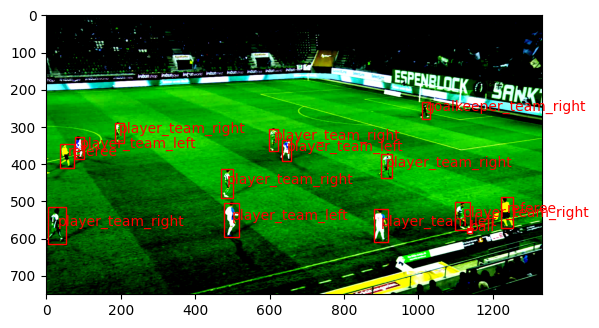

In [5]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors='pt')
    labels = [item[1] for item in batch]
    batch = {
            'pixel_values': encoding['pixel_values'],
            'pixel_mask': encoding['pixel_mask'],
            'labels': labels
        }
    return batch

# data loader for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


# visualize one image from the dataset with bounding boxes and labels
# also for each line of code, explain what it does

import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, labels = train_dataset[100]
# why? because matplotlib expects channels last format but pytorch uses channels first format
# meaning the image tensor has shape (channels, height, width) but matplotlib expects (height, width, channels)
# so permute the dimensions to match the expected format
plt.imshow(img.permute(1, 2, 0))
ax = plt.gca() # why? to get the current axes of the plot to add patches to it later on for bounding boxes and labels in the image
# axes are the subplots meaning the region of the image where the data is plotted
# so to add bounding boxes and labels to the image, we need to get the current axes of the plot
# so that we can add patches to it
# plot the bounding boxes and labels
print(labels)
for bbox, label in zip(labels["boxes"], labels["class_labels"]):
    # bbox is a tensor of shape (4,) containing the bounding box coordinates in (x, y, w, h) format and normalized to [0, 1] based on the image size
    # label is a tensor containing the class ID of the object
    # convert the bounding box coordinates to absolute values
    # convert bbox based on the image size
    bbox = [bbox[0]*img.shape[2], bbox[1]*img.shape[1], bbox[2]*img.shape[2], bbox[3]*img.shape[1]]
    #bbox[0] is center
    rect = patches.Rectangle(
        (bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1], f"{test_dataset.id_to_label[label.item()]}", color="red")
plt.show()
# for annotation in target["annotations"]:
#     bbox = annotation["bbox"]
#     category_id = annotation["category_id"]
#     # convert category_id to label
#     label = list(train_dataset.labelsToId.keys())[category_id]
#     rect = patches.Rectangle(
#         (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none"
#     )
#     ax.add_patch(rect)
#     ax.text(bbox[0], bbox[1], label, color="red")
# plt.show()

# Model

In [6]:
# create a model using torch.nn.Module for object detection
# it should have all the necessary components for object detection
# like model, optimizer, loss function, forward method,
# the model should be DeformableDetrForObjectDetection from transformers
# load the pretrained weights from SenseTime/deformable-detr
# use the AutoImageProcessor to preprocess the images
# use the Adam optimizer with a fine-tune learning rate of 1e-5

import torch
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection

class DeformableDetrForObjectDetectionModule(torch.nn.Module):
    """
    Deformable DETR model for object detection.

    Attributes:
        processor (AutoImageProcessor): A processor for preprocessing the images.
        model (DeformableDetrForObjectDetection): A Deformable DETR model for object detection
    """
    def __init__(self):
        super(DeformableDetrForObjectDetectionModule, self).__init__()
        self.processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
        self.model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr")
        # change the number of classes in the model to match the number of classes in the dataset
        self.model.config.num_classes = len(test_dataset.labelsToId)

    def forward(self, batch):
        """
        Forward pass of the model.

        Args:
            images (tensor): The input images in the shape of (batch_size, channels, height, width).
            targets (list): The target annotations for the images in COCO format.
            Each target is a dictionary containing the following keys:
            - "image_id" (int): The ID of the image.
            - "annotations" (list): A list of dictionaries containing the bounding box coordinates, category ID, and iscrowd flag for each object in the image.
        """
        # return_tensors="pt" returns the processed images as PyTorch tensors
        # inputs = self.processor(images=images, annotations=targets, return_tensors="pt")
        # **inputs unpacks the dictionary into keyword arguments for the model which expects pixel_values and annotations
        # for example, if inputs = {"pixel_values": ..., "annotations": ...}, then **inputs is equivalent to model(pixel_values=..., annotations=...)
        outputs = self.model(**batch)
        return outputs

# Training

In [7]:
#import mean average precision
from networkx import number_attracting_components
from torchmetrics.detection import MeanAveragePrecision

class Trainer:
    """
    Trainer for training the Deformable DETR model for object detection.

    Attributes:
        module (DeformableDetrForObjectDetectionModule): The Deformable DETR model for object detection.
        optimizer (torch.optim.Adam): The Adam optimizer for training the model.
        criterion (callable): The loss function for training the model.
    """
    def __init__(self, module, optimizer, device):
        self.module = module
        self.optimizer = optimizer
        # self.criterion = criterion
        # self.compute_metric = compute_metric
        # move module to device
        self.device = device
        self.module.to(device)


    def train_epoch(self, train_loader):
        self.module.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            # move batch to device
            # while pixel_values is a tensor, labels is a list of dictionaries for each image
            # each dictionary contains size, is_crowd, bbox of all, labels of all
            batch['pixel_values']  = batch['pixel_values'].to(self.device)
            batch['pixel_mask'] = batch['pixel_mask'].to(self.device)
            batch['labels'] = [{k: v.to(self.device) for k, v in t.items()} for t in batch['labels']]

            outputs = self.module(batch)

            self.optimizer.zero_grad()
            self.optimizer.step()

            loss = outputs.loss
            loss_dict = outputs.loss_dict
            total_loss += loss.item()

            print(f"batch: {batch_idx}, train_loss: {loss.item()}, train_loss_dict: {loss_dict}")


        avg_loss = total_loss / len(train_loader)
        return avg_loss

    def val_epoch(self, val_loader):
        self.module.eval()
        total_loss = 0
        metric = MeanAveragePrecision()

        for batch_idx, batch in enumerate(val_loader):
            # move batch to device
            batch['pixel_values']  = batch['pixel_values'].to(self.device)
            batch['pixel_mask'] = batch['pixel_mask'].to(self.device)
            batch['labels'] = [{k: v.to(self.device) for k, v in t.items()} for t in batch['labels']]


            outputs = self.module(batch)

            # Assume the existence of self.module.model.config.num_classes and outputs/logits, etc.

            # Extract loss and accumulate
            loss = outputs.loss
            loss_dict = outputs.loss_dict()
            total_loss += loss.item()

            # Get the mask to remove the no-object class
            num_classes = self.module.model.config.num_classes
            outputs_labels = outputs.logits.argmax(-1)
            mask = (outputs_labels != num_classes)  # Shape: (batch_size, num_boxes)

            # Initialize lists for preds and targets
            preds, targets = [], []

            # Iterate through the batch
            for i in range(outputs.pred_boxes.size(0)):
                # Apply the mask directly to filter boxes and labels
                filtered_boxes = outputs.pred_boxes[i][mask[i]]
                filtered_labels = outputs_labels[i][mask[i]]

                # Convert tensors to lists of dictionaries
                preds.append({
                    "boxes": filtered_boxes.cpu().tolist(),
                    "labels": filtered_labels.cpu().tolist(),
                })

            # Process the targets (assuming batch["labels"] is a list of dictionaries)
            for img_labels in batch["labels"]:
                boxes = [label_dict["bbox"] for label_dict in img_labels]
                labels = [label_dict["label"] for label_dict in img_labels]
                targets.append({"boxes": boxes, "labels": labels})

            # Update metric
            metric.update(preds, targets)

            print(f"batch: {batch_idx}, val_loss: {loss.item()}, val_loss_dict: {loss_dict}, map: {metric}")


        avg_loss = total_loss / len(val_loader)
        metric = metric.compute()
        return avg_loss, metric

def main():
    batch_size = 8
    learning_rate = 1e-5
    num_epochs = 20

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    module = DeformableDetrForObjectDetectionModule()
    optimizer = torch.optim.AdamW(module.model.parameters(), lr=learning_rate)
    trainer = Trainer(module, optimizer, device)


    for epoch in range(num_epochs):
        train_loss = trainer.train_epoch(train_dataloader)
        val_loss, val_metrics = trainer.val_epoch(val_dataloader)

    print(f'epoch: {epoch+1}/{num_epochs}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_metric: {val_metrics}')

main()

config.json:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/161M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


batch: 0, train_loss: 1.8886969089508057, train_loss_dict: {'loss_ce': tensor(1.3415, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2461, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(280., device='cuda:0')}
batch: 1, train_loss: 1.8948216438293457, train_loss_dict: {'loss_ce': tensor(1.3417, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2451, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(279.5000, device='cuda:0')}
batch: 2, train_loss: 1.989804744720459, train_loss_dict: {'loss_ce': tensor(1.3945, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2681, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(281., device='cuda:0')}
batch: 3, train_loss: 2.0132713317871

AttributeError: 'list' object has no attribute 'to'

# Training

# Evaluation on Test

# Visualization